In [12]:
import pandas as pd
import logging
import json
from itertools import product
from datetime import datetime, timedelta

pd.set_option("display.float_format", "{:.2f}".format)

In [13]:
# Functions

def get_logger() -> logging.Logger:
    """
    Get logger instance.
    """
    level = logging.INFO
    logger = logging.getLogger(__name__)
    logger.setLevel(level)
    logger.propagate = False
    logger.handlers = []
    console_handler = logging.StreamHandler()
    console_handler.setLevel(level)
    formatter = logging.Formatter(
        "%(asctime)s %(levelname)s | %(message)s", "%Y-%m-%d %H:%M:%S"
    )
    console_handler.setFormatter(formatter)
    logger.addHandler(console_handler)

    return logger

def json_expansion(df, payload_column):
  expanded_list = []
  os_multiplier = []
  for idx, row in df[payload_column].items():
    row_update = json.loads(row)['allocations']
    row_os_multiplier = json.loads(row)['os_multiplier']

    expanded = pd.json_normalize(row_update)
    expanded['original_index'] = idx
    expanded['os_multiplier'] = row_os_multiplier

    expanded_list.append(expanded)

  return expanded_list

def cap_and_normalise(df, column):
  total_allocation = df[column].sum()
  adjusted_allocation = 1
  capped_list = []

  for index, row in df.iterrows():
      capped_allocation = min((row[column] * adjusted_allocation)/total_allocation, 100)
      total_allocation = total_allocation  - row[column]
      adjusted_allocation = adjusted_allocation - capped_allocation
      capped_list.append(capped_allocation*10000000)

  return capped_list

In [15]:
# Data ingestion

ballot_df = pd.read_csv("Voting data export final.csv")
badgeholders_df = pd.read_csv("RPGF4_badgeholders.csv")
project_metrics_df = pd.read_csv("op_rf4_impact_metrics_by_project (1).csv")

In [16]:
# Vote and voter validation

log = get_logger()

# Check if voter_address is unique
if ballot_df["Address"].nunique() == ballot_df.shape[0]:
    log.info("Check - Address is unique.")
else:
    diff = ballot_df.shape[0] - ballot_df["Address"].nunique()
    log.info(f"Check - Address is not unique. There are {diff} duplicates.")

# Check if all address in df are in df_badge_holders
voter_validity_check = ballot_df["Address"].str.lower().isin(badgeholders_df["Badgeholder"].str.lower())

if ballot_df[voter_validity_check].shape[0] == ballot_df.shape[0]:
    log.info("Check - All addresses in df are in df_badge_holders.")
else:
    diff = ballot_df.shape[0] - ballot_df[voter_validity_check].shape[0]
    log.info(f"Check - {diff} addresses in voting are not Badge Holders.")
    # print those addresses not in df_badge_holders
    display(ballot_df[voter_validity_check])

# Check if all ballots have a signature
ballot_bh_df = ballot_df[voter_validity_check]
signature_filtered_df = ballot_bh_df[ballot_bh_df['Signature'].notna()]

2024-09-17 12:28:00 INFO | Check - Address is unique.
2024-09-17 12:28:00 INFO | Check - All addresses in df are in df_badge_holders.


In [17]:
expanded_list = json_expansion(signature_filtered_df, 'Payload')
expanded_df = pd.concat(expanded_list, ignore_index=True)

result_df = expanded_df.set_index("original_index").join(ballot_df.set_index(ballot_df.index))

# Define the columns and aggregations
sum_cols = list(expanded_df.columns)
sum_cols.remove('os_multiplier')
sum_cols.remove("original_index")

unique_cols = list(ballot_df.columns) + ['os_multiplier']

# Define the aggregations
aggregations = {
    col: 'sum' for col in sum_cols
}
aggregations.update({
    col: lambda x: x.iloc[0] for col in unique_cols
})

# Group by index and use agg() to combine the values
grouped_result = result_df.groupby(result_df.index).agg(aggregations)
grouped_result['metric_total'] = grouped_result[sum_cols].sum(axis=1)

In [18]:
# Generate ImpactMetricShares by Project and Badgeholder

bh_subset = signature_filtered_df[['Address', 'Payload']]

expanded_list = []
expanded_index = []
for idx, row in bh_subset["Payload"].items():

  row_update = json.loads(row)['os_multiplier']
  expanded_list.append(row_update)
  expanded_index.append(idx)

multiplier_expanded = pd.DataFrame(
    {'original_index': expanded_index,
     'os_multiplier': expanded_list
    })

bh_subset = multiplier_expanded.set_index("original_index").join(bh_subset.set_index(bh_subset.index))

# Create a list of all possible combinations of indices
indices = list(product(project_metrics_df.index, bh_subset.index))

# Create a DataFrame with the combined indices
combined_df = pd.DataFrame(indices, columns=['index1', 'index2'])

# Perform the join using merge()
metric_sum_df = pd.merge(combined_df, project_metrics_df, left_on='index1', right_index=True) \
          .merge(bh_subset, left_on='index2', right_index=True)

for col in sum_cols:
    metric_sum_df.loc[metric_sum_df['is_oss'] == True, col] = \
    metric_sum_df.loc[metric_sum_df['is_oss'] == True, col] * metric_sum_df.loc[metric_sum_df['is_oss'] == True, 'os_multiplier']

for address in bh_subset['Address']:
    for col in sum_cols:
        metric_sum_df.loc[metric_sum_df['Address'] == address, col] = \
        metric_sum_df.loc[metric_sum_df['Address'] == address, col] / metric_sum_df.loc[metric_sum_df['Address'] == address, col].sum()

In [19]:
# Generate the Score by Badgeholder

badgeholder_allocation_df = metric_sum_df.copy()

for address in bh_subset['Address']:

    for col in sum_cols:
        if grouped_result.loc[grouped_result['Address'] == address, col].iloc[0] == 0:
          badgeholder_allocation_df.loc[badgeholder_allocation_df['Address'] == address, col] = badgeholder_allocation_df.loc[badgeholder_allocation_df['Address'] == address, col]* 0
        else:
          badgeholder_allocation_df.loc[badgeholder_allocation_df['Address'] == address, col] = badgeholder_allocation_df.loc[badgeholder_allocation_df['Address'] == address, col]* (grouped_result.loc[grouped_result['Address'] == address, col].iloc[0]/100)

# Calculate badgeholder score for each project
badgeholder_allocation_df['badgeholder_allocation'] = badgeholder_allocation_df[sum_cols].sum(axis=1)
badgeholder_allocation_df.to_csv('badgeholder_allocation_df.csv',index=False)

badgeholder_allocation_df.head(100)

,index1,index2,project_name,application_id,is_oss,gas_fees,transaction_count,trusted_transaction_count,trusted_transaction_share,trusted_users_onboarded,...,trusted_recurring_users,power_user_addresses,openrank_trusted_users_count,log_gas_fees,log_transaction_count,log_trusted_transaction_count,os_multiplier,Address,Payload,badgeholder_allocation
0,0,0,Aave,0x3061b642db56c507e265f03029735b0413a613bda434...,True,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.80,0x55aed0ce035883626e536254dda2f23a5b5d977f,"{""allocations"":[{""trusted_daily_active_users"":...",0.01
1,0,1,Aave,0x3061b642db56c507e265f03029735b0413a613bda434...,True,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0x3b60e31cfc48a9074cd5bebb26c9eaa77650a43f,"{""allocations"":[{""trusted_users_onboarded"":20}...",0.01
2,0,2,Aave,0x3061b642db56c507e265f03029735b0413a613bda434...,True,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0x512fce9b07ce64590849115ee6b32fd40ec0f5f3,"{""allocations"":[{""gas_fees"":25.002499750025},{...",0.01
3,0,3,Aave,0x3061b642db56c507e265f03029735b0413a613bda434...,True,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0xd8da6bf26964af9d7eed9e03e53415d37aa96045,"{""allocations"":[{""openrank_trusted_users_count...",0.01
4,0,4,Aave,0x3061b642db56c507e265f03029735b0413a613bda434...,True,0.00,0.00,0.00,0.00,0.00,...,0.01,0.00,0.00,0.00,0.00,0.00,3.00,0x616cad18642f45d3fa5fcaad0a2d81764a9cba84,"{""allocations"":[{""trusted_recurring_users"":40}...",0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,95,Aave,0x3061b642db56c507e265f03029735b0413a613bda434...,True,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,2.30,0xaeb99a255c3a243ab3e4f654041e9bf5340cf313,"{""allocations"":[{""trusted_users_onboarded"":13}...",0.01
96,0,96,Aave,0x3061b642db56c507e265f03029735b0413a613bda434...,True,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,3.00,0x5872ce037211233b9f6f5095c25988021f270c21,"{""allocations"":[{""trusted_recurring_users"":18}...",0.02
97,0,97,Aave,0x3061b642db56c507e265f03029735b0413a613bda434...,True,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,3.00,0xdca1bb1fc782ea3fa76ea4ada42af10c85766b6a,"{""allocations"":[{""trusted_users_onboarded"":25}...",0.01
98,0,98,Aave,0x3061b642db56c507e265f03029735b0413a613bda434...,True,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0x1c9a6c17ba87451520cc4aa4ca63db07dc180242,"{""allocations"":[{""trusted_users_onboarded"":25....",0.01


In [20]:
median_score_df = badgeholder_allocation_df.copy()

updated_median_df = pd.DataFrame()
capped_list = []

for address in bh_subset['Address']:
  df = median_score_df.loc[median_score_df['Address'] == address].sort_values(by ='badgeholder_allocation', ascending=False)
  updated_median_df = pd.concat([updated_median_df, df], ignore_index=True)

  # Normalise and re-cap score values
  if not capped_list:
    capped_list = cap_and_normalise(df,'badgeholder_allocation')
  else:
    capped_list = capped_list + cap_and_normalise(df,'badgeholder_allocation')

updated_median_df['badgeholder_score'] = capped_list
median_scores = updated_median_df.groupby(['project_name','application_id']).agg(median_score=('badgeholder_score', 'median'))

In [21]:
# Generate final allocation by applying cap and normalizing to 10M

# Normalise and re-cap score values
final_median_scores = median_scores.copy().sort_values(by ='median_score', ascending=False)
final_median_scores['adjusted_score'] = cap_and_normalise(final_median_scores, 'median_score')

# Filter out projects with a badgeholder_score of less than 1000
filtered_median_scores = final_median_scores[final_median_scores['adjusted_score'] > 0].sort_values(by ='adjusted_score', ascending=False)
filtered_median_scores['final_score'] = cap_and_normalise(filtered_median_scores, 'adjusted_score')

# Round score columns to 1 decimal place
cols_to_round = ['median_score', 'adjusted_score', 'final_score']
for col in cols_to_round:
    filtered_median_scores[col] = filtered_median_scores[col].round(1).astype(object)

filtered_median_scores = filtered_median_scores.sort_values(by = 'final_score', ascending=False)
filtered_median_scores

,,median_score,adjusted_score,final_score
project_name,application_id,,,
Zora,0x9102357674825ed224734387fbefbf41c16fe5d9764c2f7f3e897ad3325d3990,1334281.30,1457781.00,1457781.00
Layer3,0x91a4420e2fcc8311e97dad480f201a8ce221f2cd64c2de77280cbcc6ce193752,668935.60,730851.60,730851.60
LI.FI,0x517eaa9c56951de89261f2d7830ea49aae92f2a903104a17d9c5c2edd4959806,395922.00,432568.10,432568.10
Stargate Finance,0x62e37e96aa6e1cbfb6bd24b97c4b8f1e12cc3fe35d5388d2f041c42a12b40745,333959.30,364870.20,364870.20
ODOS,0xd5b4c54b12bf86f6eb67fec81032809a16ff1c4b4c7f0d5898fc86367db86ca6,281095.80,307113.70,307113.70
...,...,...,...,...
Based Bodega,0xdbfb85445c76c4dc1f6f3992098713ba07857f3417951184bfb6a7e65f14807c,102.30,111.80,111.80
Ambire,0xb908ea18fd164cf089649ba95887c221f5e8b93a08235dff43e33bd6617239dc,88.40,96.50,96.50
Talent Protocol,0x2e0e80846b4d52b126f3c9a20a01876bbcb80de67befe916870c5d8736af6c2a,68.10,74.40,74.40


# Develop Voting Matrix

In [56]:
# Get the unique project names from the DataFrame
unique_projects = badgeholder_allocation_df['project_name'].unique()

# Initialize a dictionary to store project allocations
project_allocations = {}

# Loop through each project and extract the badgeholder allocations for that project
for project in unique_projects:
    # Filter the rows for the current project
    project_df = badgeholder_allocation_df[badgeholder_allocation_df['project_name'] == project]
    
    # Get the badgeholder allocations as an array for the current project
    badgeholder_allocation_array = project_df['badgeholder_allocation'].values
    
    # Store the array in the dictionary with the project name as the key
    project_allocations[project] = badgeholder_allocation_array

# Show the allocations for a few projects
#{project: project_allocations[project] for project in list(project_allocations.keys())[:5]}


In [65]:

# Get the unique badgeholder addresses and projects to structure the data
unique_badgeholders = badgeholder_allocation_df['Address'].unique()

# Initialize a 2D numpy array to store the allocations
allocation_matrix = []

# Loop through each project and get badgeholder allocations in the same order for each project
for project in unique_projects:
    # Filter rows corresponding to the current project
    project_df = badgeholder_allocation_df[badgeholder_allocation_df['project_name'] == project]
    
    # Create an array of allocations for this project with respect to each badgeholder
    project_allocations = []
    for badgeholder in unique_badgeholders:
        # Get the allocation for this badgeholder in the current project, or 0 if missing
        allocation = project_df[project_df['Address'] == badgeholder]['badgeholder_allocation'].sum()  # sum() ensures 0 if no allocation exists
        project_allocations.append(allocation)
    
    # Add this project's allocations as a row in the matrix
    allocation_matrix.append(project_allocations)

# Convert the list to a numpy array
allocation_matrix = np.array(allocation_matrix)

# Display the matrix for the first few projects and badgeholders
voting_matrix=allocation_matrix#*10e6
voting_matrix.shape

# Transpose the voting_matrix to invert rows and columns
voting_matrix = voting_matrix.T

# Check the new shape of the matrix
voting_matrix.shape

  # Display first 5 projects and first 5 badgeholders

(108, 230)

In [66]:
voting_matrix

array([[1.10336092e-02, 6.27821075e-04, 3.02509642e-03, ...,
        5.63661867e-04, 1.72158285e-03, 1.26570625e-03],
       [6.21537189e-03, 2.55479327e-04, 1.62665359e-04, ...,
        1.51224494e-04, 8.49413776e-04, 2.11559101e-03],
       [6.64466174e-03, 9.10333446e-04, 1.27618992e-02, ...,
        1.41770108e-03, 1.49599265e-03, 1.25463068e-03],
       ...,
       [1.40593681e-02, 1.62821036e-04, 7.89127222e-04, ...,
        7.08295314e-05, 1.66558567e-03, 4.90935245e-04],
       [9.56740968e-03, 8.43825253e-05, 1.09535392e-04, ...,
        1.03200092e-04, 8.73376236e-04, 4.50267667e-04],
       [1.18384603e-02, 8.49721836e-04, 5.86344211e-04, ...,
        4.49791090e-04, 1.47213909e-03, 2.42835984e-03]])

# Voting Rules

In [69]:
import numpy as np

def majoritarian_moving_phantoms(voting_matrix, total_op_tokens, num_voters):
    num_voters, num_projects = voting_matrix.shape

    def f_k(t, k, num_voters):
        if t <= k / (num_voters + 1):
            return 0
        elif t < (k + 1) / (num_voters + 1):
            return (num_voters + 1) * t - k
        else:
            return 1

    def median_with_phantoms(t_star, j):
        phantom_votes = [f_k(t_star, k, num_voters) for k in range(num_voters + 1)]
        real_votes = voting_matrix[:, j] / sum(voting_matrix[0])  # Normalize real votes
        return np.median(phantom_votes + list(real_votes))

    def find_t_star():
        low, high = 0.0, 1.0
        epsilon = 1e-9
        while high - low > epsilon:
            mid = (low + high) / 2
            if sum(median_with_phantoms(mid, j) for j in range(num_projects)) > 1:
                high = mid
            else:
                low = mid
        return low

    t_star = find_t_star()
    distribution = np.array([median_with_phantoms(t_star, j) for j in range(num_projects)])
    best_distribution = distribution * (total_op_tokens / np.sum(distribution))
    return best_distribution

import numpy as np

def pure_median(voting_matrix):
    num_voters, num_projects = voting_matrix.shape
    
    # Step 1: Calculate the median including zeros
    median_allocation = np.median(voting_matrix, axis=0)
    
    return median_allocation

def normalized_median(voting_matrix, total_op_tokens):
    num_voters, num_projects = voting_matrix.shape
    
    # Step 1: Calculate the median including zeros
    median_votes = np.median(voting_matrix, axis=0)
    
    # Step 2: Apply eligibility criteria (if needed) or directly use the median
    #MIN_AMOUNT = 0  # Set the minimum threshold (optional)
    #eligible_projects = median_votes >= MIN_AMOUNT
    eligible_median_votes = median_votes #ß* eligible_projects
    
    # Step 3: Scale the eligible median votes to match the total_op_tokens
    if np.sum(eligible_median_votes) == 0:
        return np.zeros_like(eligible_median_votes)  # Avoid division by zero
    
    scaled_allocations = (eligible_median_votes / np.sum(eligible_median_votes)) * total_op_tokens
    
    return scaled_allocations

def r3_median(voting_matrix, total_op_tokens):
        num_voters, num_projects = voting_matrix.shape
        # Step 1: Calculate the median, ignoring zeros
        MIN_AMOUNT = 0
        def non_zero_median(column):
            non_zero_values = column[column > 0]
            if len(non_zero_values) == 0:
                return 0
            return np.median(non_zero_values)
        
        median_votes = np.apply_along_axis(non_zero_median, 0, voting_matrix)
        
        # Step 2: Apply eligibility criteria (median >= MIN_AMOUNT)
        
        eligible_projects = median_votes >= MIN_AMOUNT
        eligible_median_votes = median_votes * eligible_projects
        
        # Step 3: Scale the eligible median votes to match the total_op_tokens
        if np.sum(eligible_median_votes) == 0:
            return np.zeros_like(eligible_median_votes)  # Avoid division by zero
        
        scaled_allocations = (eligible_median_votes / np.sum(eligible_median_votes)) * total_op_tokens
        
        return scaled_allocations

def r4_capped_median(voting_matrix, total_op_tokens, num_voters):
    num_voters, num_projects = voting_matrix.shape

    # K1 is the maximum number of tokens a single voter can allocate to a single project before redistribution is triggered.
    K1 = 10e6#500000
    # K2 is the maximum median allocation a project can receive before redistribution is triggered.
    K2 = 10e6
    # K3 is the minimum allocation required for a project to receive funding; projects below this threshold are eliminated, and their funds are redistributed.
    K3 = 0#1000

    # Step 1: Cap at K1 for each voter
    capped_scores = np.minimum(voting_matrix, K1)
    excess_scores = np.maximum(0, voting_matrix - K1)

    redistributed_scores = capped_scores.copy()
    
    for i in range(num_voters):
        uncapped_projects = capped_scores[i] < K1
        
        if np.any(uncapped_projects):
            uncapped_project_indices = np.where(uncapped_projects)[0]
            relevant_capped_scores = capped_scores[i, uncapped_project_indices]
            relevant_excess_scores = excess_scores[i, uncapped_project_indices]
            
            if np.sum(relevant_capped_scores) > 0:
                proportionate_excess = (relevant_excess_scores * relevant_capped_scores) / np.sum(relevant_capped_scores)
                redistributed_scores[i, uncapped_project_indices] += proportionate_excess

    # Step 2: Calculate medians
    median_scores = np.median(redistributed_scores, axis=0)

    # Step 3: Cap at K2 and redistribute
    capped_median_scores = np.minimum(median_scores, K2)
    excess_median = np.maximum(0, median_scores - K2)

    # Total excess after capping at K2
    total_excess_median = np.sum(excess_median)

    # Step 4: Redistribution of excess from K2 to only projects below K2
    eligible_projects = capped_median_scores < K2
    redistributed_median_scores = capped_median_scores.copy()

    while total_excess_median > 0:
        eligible_for_redistribution = capped_median_scores < K2  # Only redistribute to projects under K2
        
        if np.any(eligible_for_redistribution) and np.sum(capped_median_scores[eligible_for_redistribution]) > 0:
            # Redistribute excess only to eligible projects
            redistributed_median_scores[eligible_for_redistribution] += (
                (total_excess_median * capped_median_scores[eligible_for_redistribution]) 
                / np.sum(capped_median_scores[eligible_for_redistribution])
            )

        # Recalculate excess after redistribution
        total_excess_median = np.sum(np.maximum(0, redistributed_median_scores - K2))
        redistributed_median_scores = np.minimum(redistributed_median_scores, K2)  # Cap at K2 again

    # Step 5: Normalize to the total budget
    final_scores = redistributed_median_scores / np.sum(redistributed_median_scores) * total_op_tokens

    # Step 6: Eliminate projects with allocation below K3 and redistribute
    low_allocation_projects = final_scores < K3
    if np.any(low_allocation_projects):
        redistributed_amount = np.sum(final_scores[low_allocation_projects])
        eligible_for_redistribution = (final_scores >= K3) & (final_scores < K2)  # Only redistribute to projects below K2
        if np.any(eligible_for_redistribution) and np.sum(final_scores[eligible_for_redistribution]) > 0:
            final_scores[eligible_for_redistribution] += (redistributed_amount * final_scores[eligible_for_redistribution]) / np.sum(final_scores[eligible_for_redistribution])
        final_scores[low_allocation_projects] = 0

    # Step 7: Final normalization and capping
    total_allocated = np.sum(final_scores)
    if total_allocated > 0:
        final_allocation = final_scores / total_allocated * total_op_tokens
    else:
        final_allocation = final_scores

    return np.minimum(final_allocation, K2)  # Ensure final capping




# Phantoms and Op R4 Comparison

In [50]:
num_voters = voting_matrix.shape[0]
num_projects = voting_matrix.shape[1]
total_op_tokens = 10e6  # Adjust to your actual value

# Call the Majoritarian Moving Phantoms method
phantoms_allocation = majoritarian_moving_phantoms(voting_matrix, total_op_tokens, num_voters)

project_names = unique_projects[:len(phantoms_allocation)]  # Limiting to match length of allocations

# Create a DataFrame with project names and phantom allocations
phantoms_allocation_df = pd.DataFrame({
    'project_name': project_names,
    'phantoms_allocation': phantoms_allocation
})

# Display the DataFrame
phantoms_allocation_df.head(300)


,project_name,phantoms_allocation
0,Aave,115297.99
1,Alchemix,2669.71
2,Biconomy,10672.66
3,0x Protocol,289821.32
4,CreateMyToken,0.27
...,...,...
225,sudoswap,15924.63
226,tanX - The World's Leading Institutional DEX,10100.49
227,zkBob smart contract privacy wallet,3489.27
228,🏰 BuidlGuidl,17181.81


In [347]:
median_allocation=r4_capped_median(voting_matrix,10e6,num_voters)
project_names = unique_projects[:len(median_allocation)]  # Limiting to match length of allocations

# Create a DataFrame with project names and phantom allocations
median_allocation_df = pd.DataFrame({
    'project_name': project_names,
    'median_allocation': median_allocation
})

# Display the DataFrame
median_allocation_df=median_allocation_df.sort_values(by='median_allocation', ascending=False)
median_allocation_df

,project_name,median_allocation
216,Zora,1457782.77
104,Layer3,730852.47
103,LI.FI,432568.65
177,Stargate Finance,364870.64
129,ODOS,307114.09
...,...,...
32,Based Bodega,111.80
17,Ambire,96.54
191,Talent Protocol,74.36
5,Poster,1.13


In [348]:
# Assuming the three DataFrames are named: phantoms_allocation_df, filtered_median_scores, and median_allocation_df

# Merge the first two DataFrames (phantoms_allocation_df and filtered_median_scores) on 'project_name'
merged_df = pd.merge(phantoms_allocation_df, filtered_median_scores, on='project_name', how='left')

# Then merge the result with the third DataFrame (median_allocation_df) on 'project_name'
merged_df = pd.merge(merged_df, median_allocation_df, on='project_name', how='left')

# Fill any NaN values with 0
merged_df = merged_df.fillna(0)

# Sort the DataFrame in descending order based on the 'final_scores' column (assuming this column exists)
merged_df = merged_df.sort_values(by='final_score', ascending=False)

# Save the merged DataFrame to a CSV file
merged_df.to_csv("/Users/idrees/Code/govxs/data/r4_data/combined_allocation_results_without_caps.csv", index=False)

# Display the top 10 rows of the merged DataFrame
merged_df.head(300)


/var/folders/jc/585j6n692cs_9w0hfdcpf43w0000gn/T/ipykernel_65432/2682517763.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df = merged_df.fillna(0)


,project_name,phantoms_allocation,median_score,adjusted_score,final_score,median_allocation
216,Zora,1394006.31,1334281.30,1457781.00,1457781.00,1457782.77
104,Layer3,726651.29,668935.60,730851.60,730851.60,730852.47
103,LI.FI,421732.75,395922.00,432568.10,432568.10,432568.65
177,Stargate Finance,343959.67,333959.30,364870.20,364870.20,364870.64
129,ODOS,293835.90,281095.80,307113.70,307113.70,307114.09
...,...,...,...,...,...,...
32,Based Bodega,127.32,102.30,111.80,111.80,111.80
17,Ambire,121.65,88.40,96.50,96.50,96.54
191,Talent Protocol,90.55,68.10,74.40,74.40,74.36
5,Poster,1.40,1.00,1.10,1.10,1.13


In [349]:
# Assuming both DataFrames have a 'project_name' column

# Merge the DataFrames on 'project_name'
merged_df = pd.merge(phantoms_allocation_df, filtered_median_scores, on='project_name', how='left')
merged_df = merged_df.fillna(0)
# Sort the DataFrame in descending order based on the 'final_scores' column

merged_df.to_csv("combined_allocation_results.csv", index=False)

# Display the merged DataFrame
merged_df.head (10)


/var/folders/jc/585j6n692cs_9w0hfdcpf43w0000gn/T/ipykernel_65432/802019720.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df = merged_df.fillna(0)


,project_name,phantoms_allocation,median_score,adjusted_score,final_score
0,Aave,115297.99,112349.90,122748.90,122748.90
1,Alchemix,2669.71,1675.20,1830.20,1830.20
2,Biconomy,10672.66,9138.10,9983.90,9983.90
3,0x Protocol,289821.32,280258.30,306198.70,306198.70
4,CreateMyToken,0.27,0.20,0.20,0.20
5,Poster,1.40,1.00,1.10,1.10
6,Loot2,16380.13,14973.50,16359.40,16359.40
7,Wombat Exchange,3726.64,2598.10,2838.60,2838.60
8,Ethereum Attestation Service (EAS),38843.78,36522.10,39902.60,39902.60
9,Wormhole Foundation,24346.75,21630.10,23632.20,23632.20


In [350]:
merged_df_sorted = merged_df.sort_values(by='final_score', ascending=False)
merged_df_sorted

,project_name,phantoms_allocation,median_score,adjusted_score,final_score
216,Zora,1394006.31,1334281.30,1457781.00,1457781.00
104,Layer3,726651.29,668935.60,730851.60,730851.60
103,LI.FI,421732.75,395922.00,432568.10,432568.10
177,Stargate Finance,343959.67,333959.30,364870.20,364870.20
129,ODOS,293835.90,281095.80,307113.70,307113.70
...,...,...,...,...,...
32,Based Bodega,127.32,102.30,111.80,111.80
17,Ambire,121.65,88.40,96.50,96.50
191,Talent Protocol,90.55,68.10,74.40,74.40
5,Poster,1.40,1.00,1.10,1.10


# Comparison of Results

In [351]:
import matplotlib.pyplot as plt
df=merged_df
summary_stats = df[['phantoms_allocation', 'final_score']].describe()
summary_stats

,phantoms_allocation,final_score
count,230.00,230.00
mean,43478.26,43478.26
std,116248.61,120195.27
min,0.27,0.20
25%,3998.10,3038.00
50%,11909.46,11345.50
75%,40279.39,39931.55
max,1394006.31,1457781.00


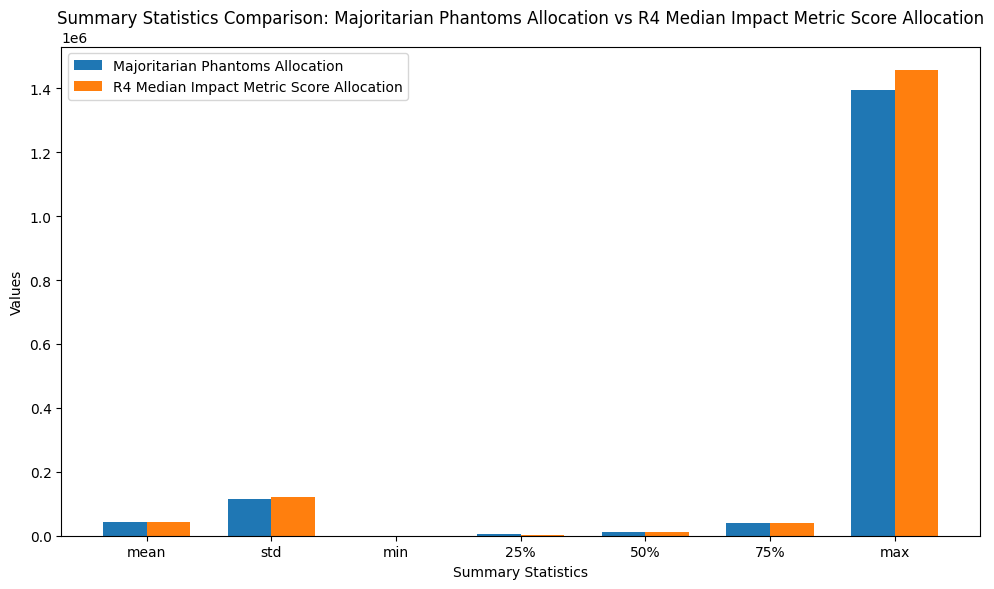

In [352]:
# Extracting summary statistics for both Phantoms Allocation and Final Score
summary_stats = df[['phantoms_allocation', 'final_score']].describe()

# Plotting the summary statistics
plt.figure(figsize=(10, 6))

# Plotting mean, 25th percentile, median, 75th percentile, and max
summary_stat_columns = ['mean', 'std', 'min', '25%', '50%', '75%', 'max']
phantoms_summary = summary_stats.loc[summary_stat_columns, 'phantoms_allocation']
final_score_summary = summary_stats.loc[summary_stat_columns, 'final_score']

# Create a bar plot for summary stats
bar_width = 0.35
index = range(len(summary_stat_columns))

plt.bar(index, phantoms_summary, bar_width, label='Majoritarian Phantoms Allocation', align='center')
plt.bar([i + bar_width for i in index], final_score_summary, bar_width, label='R4 Median Impact Metric Score Allocation', align='center')

# Add labels and title
plt.xlabel('Summary Statistics')
plt.ylabel('Values')
plt.title('Summary Statistics Comparison: Majoritarian Phantoms Allocation vs R4 Median Impact Metric Score Allocation')
plt.xticks([i + bar_width / 2 for i in index], summary_stat_columns)

# Add legend
plt.legend()

plt.tight_layout()

# Display the plot
plt.show()


/var/folders/jc/585j6n692cs_9w0hfdcpf43w0000gn/T/ipykernel_65432/3590423042.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df['phantoms_allocation'], df['final_score']], labels=['Phantoms Allocation', 'Final Score'])


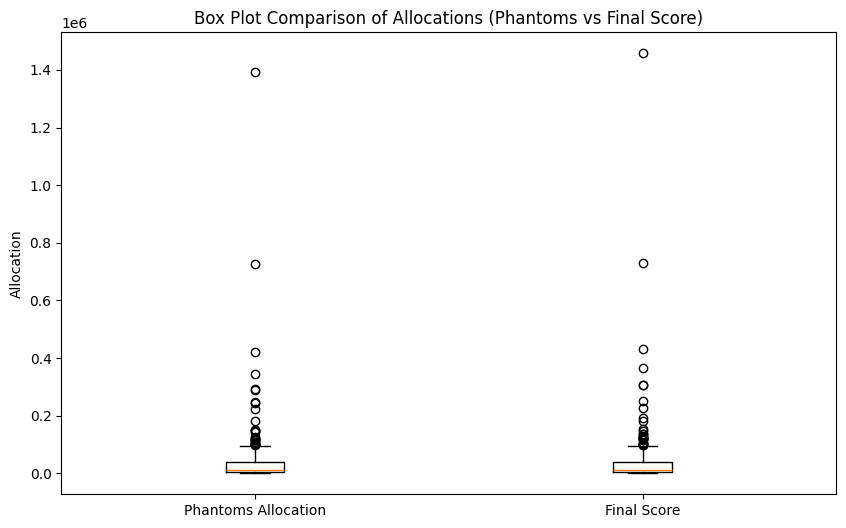

In [353]:
# Plot all projects in a simple bar plot for both voting rules
import matplotlib.pyplot as plt
df=merged_df
summary_stats = df[['phantoms_allocation', 'final_score']].describe()

# Create box plots for both voting rules to visualize the distributions
plt.figure(figsize=(10, 6))

# Box plot for phantoms_allocation and final_score
plt.boxplot([df['phantoms_allocation'], df['final_score']], labels=['Phantoms Allocation', 'Final Score'])

# Add labels and title
plt.title('Box Plot Comparison of Allocations (Phantoms vs Final Score)')
plt.ylabel('Allocation')

# Display the box plots
plt.show()


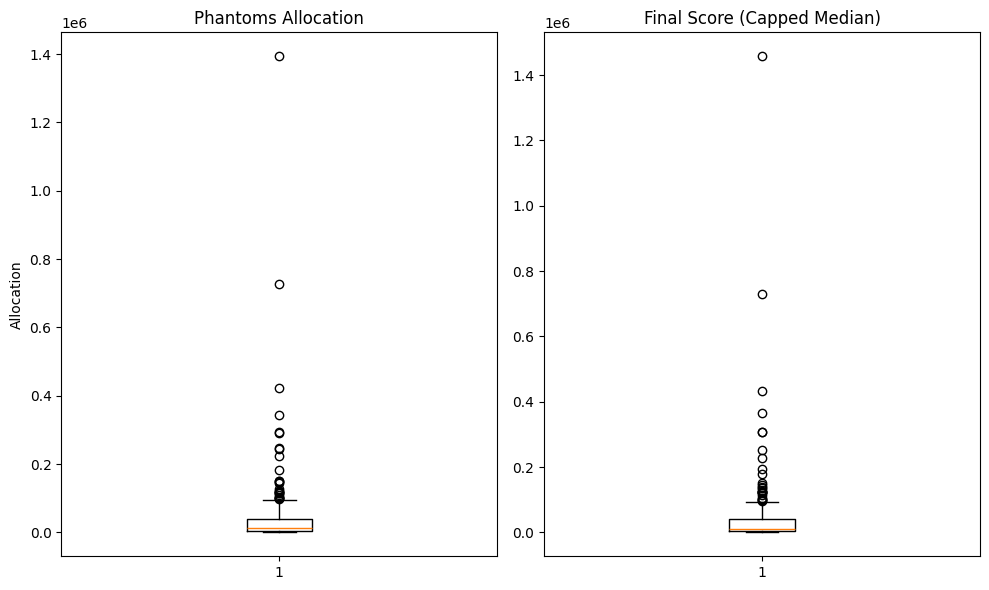

In [354]:
# Create separate box plots for Phantoms Allocation and Final Score

plt.figure(figsize=(10, 6))

# Subplot 1: Box plot for Phantoms Allocation
plt.subplot(1, 2, 1)
plt.boxplot(df['phantoms_allocation'])
plt.title('Phantoms Allocation')
plt.ylabel('Allocation')

# Subplot 2: Box plot for Final Score
plt.subplot(1, 2, 2)
plt.boxplot(df['final_score'])
plt.title('Final Score (Capped Median)')

# Adjust layout for clarity
plt.tight_layout()

# Display the separate box plots
plt.show()

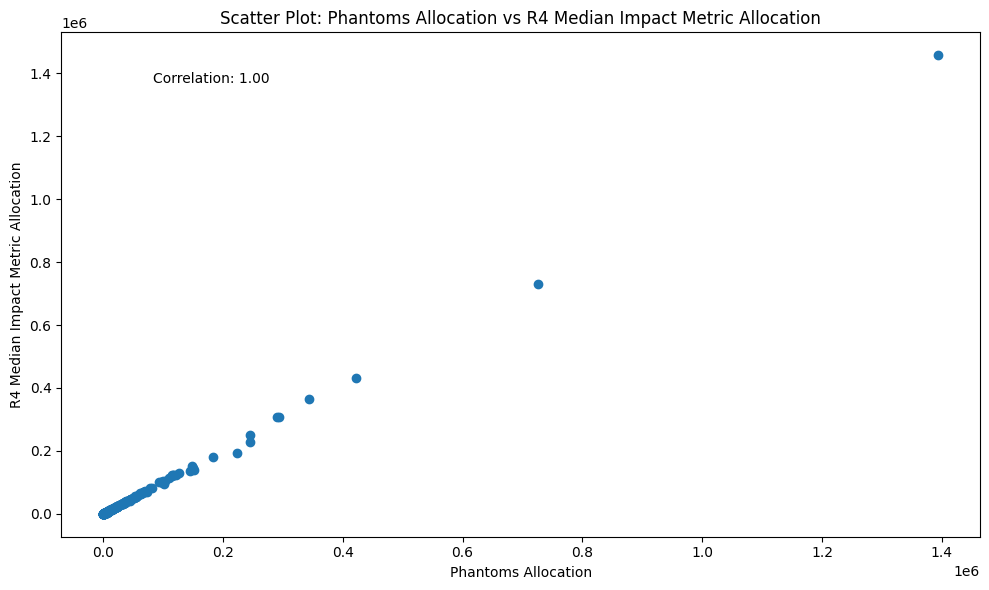

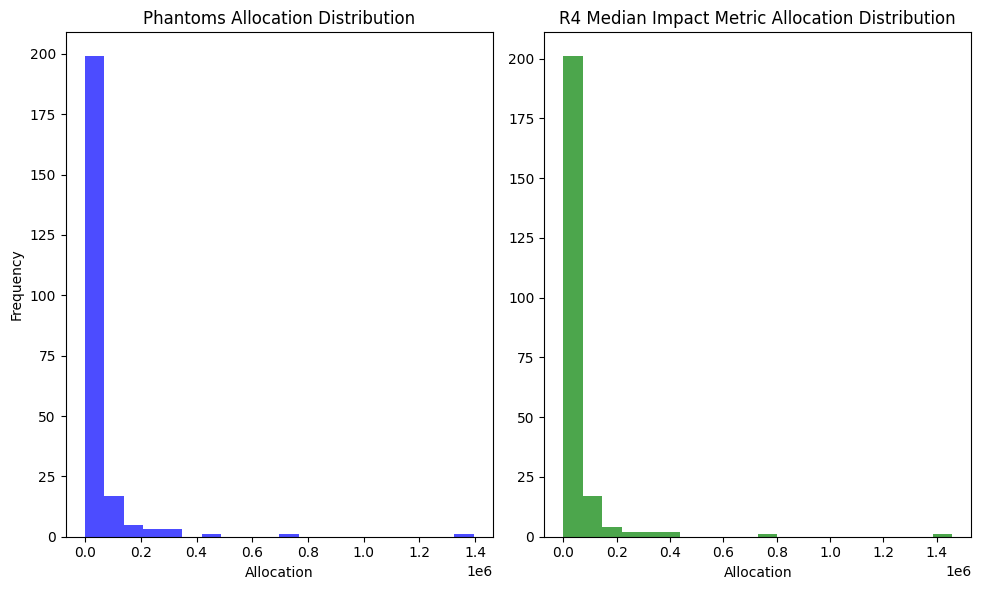

/var/folders/jc/585j6n692cs_9w0hfdcpf43w0000gn/T/ipykernel_65432/1531713820.py:42: UserWarning: Glyph 127984 (\N{EUROPEAN CASTLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/jc/585j6n692cs_9w0hfdcpf43w0000gn/T/ipykernel_65432/1531713820.py:42: UserWarning: Glyph 128081 (\N{CROWN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/jc/585j6n692cs_9w0hfdcpf43w0000gn/T/ipykernel_65432/1531713820.py:42: UserWarning: Glyph 127913 (\N{TOP HAT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/jc/585j6n692cs_9w0hfdcpf43w0000gn/T/ipykernel_65432/1531713820.py:42: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/Users/idrees/Code/govxs/govxs_venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127984 (\N{EUROPEAN CASTLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Use

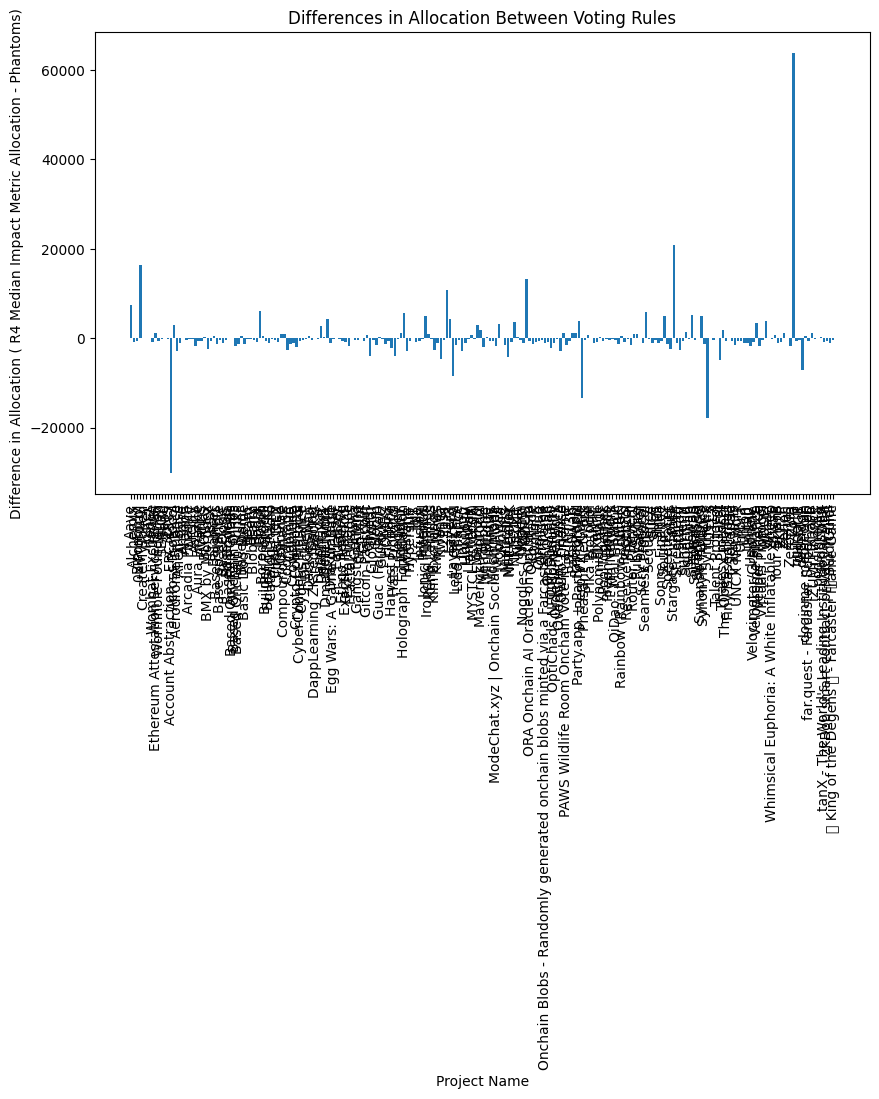

/var/folders/jc/585j6n692cs_9w0hfdcpf43w0000gn/T/ipykernel_65432/1531713820.py:53: UserWarning: Glyph 127984 (\N{EUROPEAN CASTLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/jc/585j6n692cs_9w0hfdcpf43w0000gn/T/ipykernel_65432/1531713820.py:53: UserWarning: Glyph 128081 (\N{CROWN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/jc/585j6n692cs_9w0hfdcpf43w0000gn/T/ipykernel_65432/1531713820.py:53: UserWarning: Glyph 127913 (\N{TOP HAT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/jc/585j6n692cs_9w0hfdcpf43w0000gn/T/ipykernel_65432/1531713820.py:53: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/Users/idrees/Code/govxs/govxs_venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127984 (\N{EUROPEAN CASTLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Use

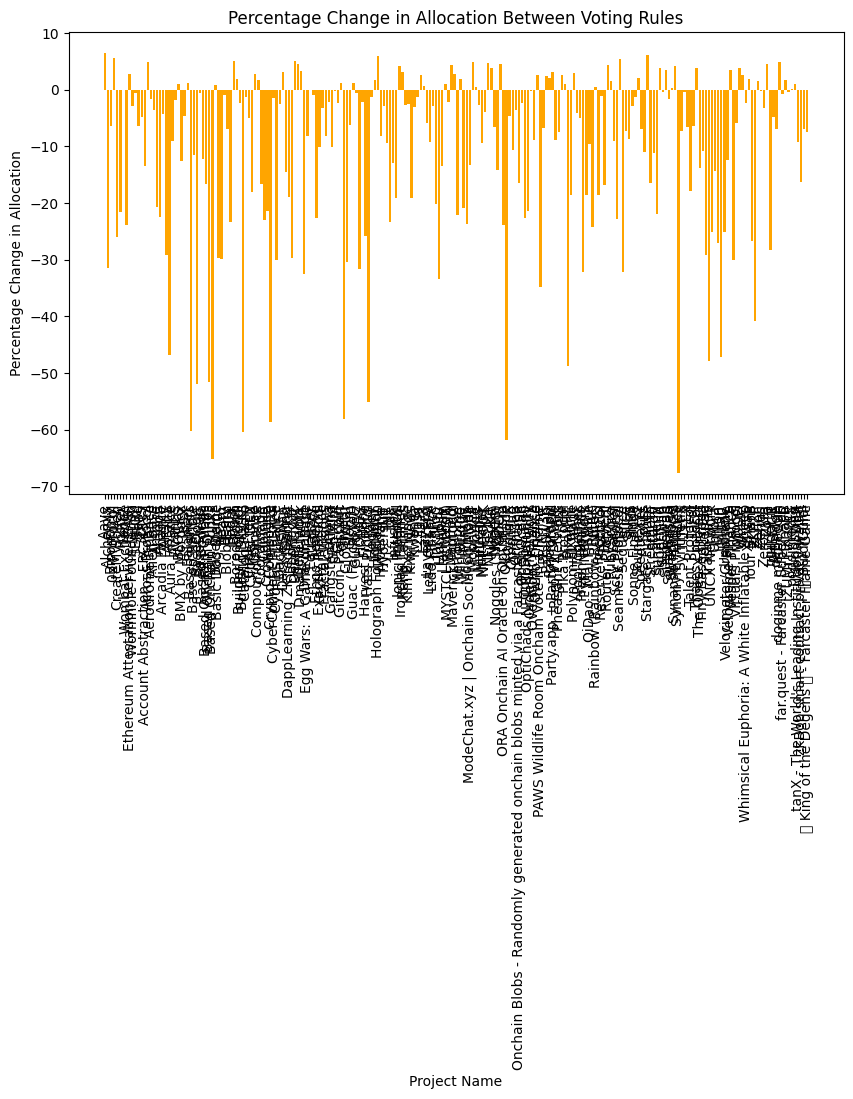

<Figure size 1000x600 with 0 Axes>

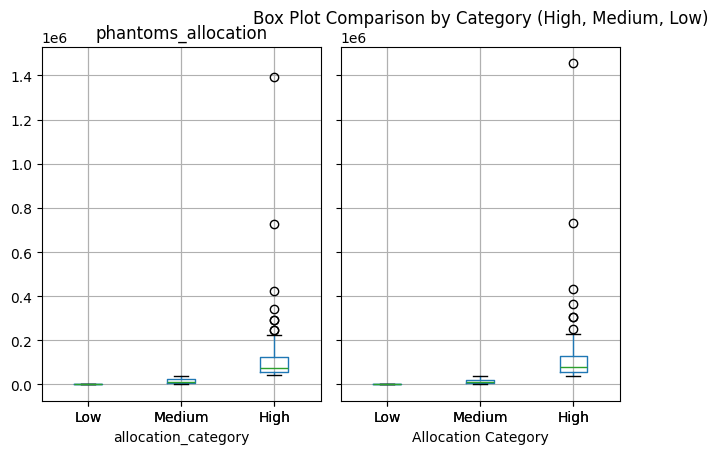

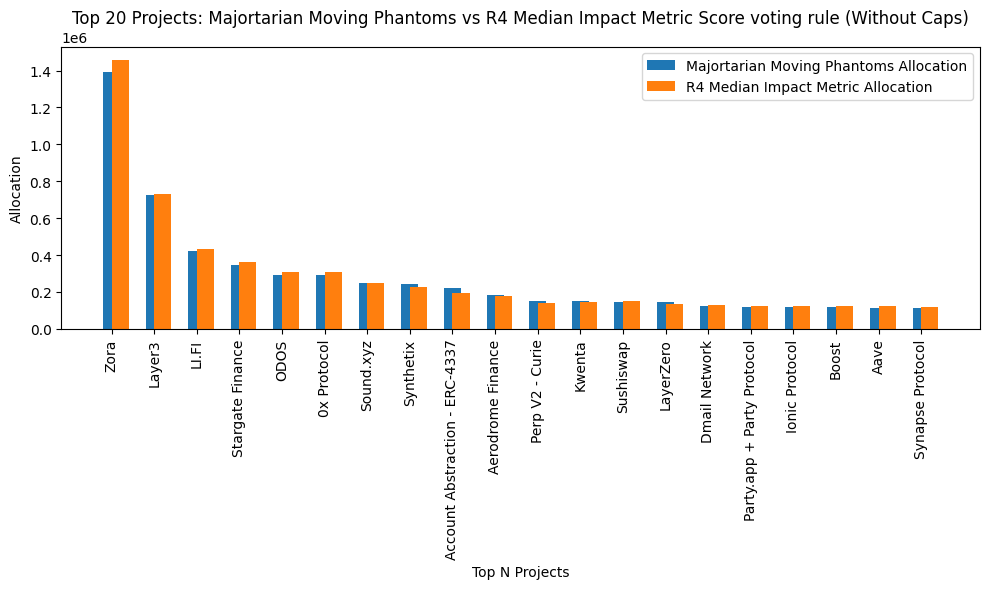

In [355]:
# Scatter Plot with Correlation
plt.figure(figsize=(10, 6))
plt.scatter(df['phantoms_allocation'], df['final_score'])
plt.xlabel('Phantoms Allocation')
plt.ylabel('R4 Median Impact Metric Allocation')
plt.title('Scatter Plot: Phantoms Allocation vs R4 Median Impact Metric Allocation')

# Calculate and display correlation
correlation = df['phantoms_allocation'].corr(df['final_score'])
plt.text(0.1, 0.9, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

# Histogram for Phantoms Allocation and Final Score
plt.figure(figsize=(10, 6))

# Histogram for Phantoms Allocation
plt.subplot(1, 2, 1)
plt.hist(df['phantoms_allocation'], bins=20, color='blue', alpha=0.7)
plt.title('Phantoms Allocation Distribution')
plt.xlabel('Allocation')
plt.ylabel('Frequency')

# Histogram for Final Score
plt.subplot(1, 2, 2)
plt.hist(df['final_score'], bins=20, color='green', alpha=0.7)
plt.title('R4 Median Impact Metric Allocation Distribution')
plt.xlabel('Allocation')

plt.tight_layout()
plt.show()

# Differences Plot
df['allocation_difference'] = df['final_score'] - df['phantoms_allocation']
plt.figure(figsize=(10, 6))
plt.bar(df['project_name'], df['allocation_difference'])
plt.xlabel('Project Name')
plt.ylabel('Difference in Allocation ( R4 Median Impact Metric Allocation - Phantoms)')
plt.title('Differences in Allocation Between Voting Rules')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Relative Change Plot
df['allocation_percentage_change'] = ((df['final_score'] - df['phantoms_allocation']) / df['phantoms_allocation']) * 100
plt.figure(figsize=(10, 6))
plt.bar(df['project_name'], df['allocation_percentage_change'], color='orange')
plt.xlabel('Project Name')
plt.ylabel('Percentage Change in Allocation')
plt.title('Percentage Change in Allocation Between Voting Rules')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Box Plot Comparison with Sub-groups (High, Medium, Low)
# Define thresholds for High, Medium, Low
thresholds = {
    'High': df['phantoms_allocation'].quantile(0.75),
    'Low': df['phantoms_allocation'].quantile(0.25)
}

# Create a category column
df['allocation_category'] = pd.cut(df['phantoms_allocation'], 
                                   bins=[-1, thresholds['Low'], thresholds['High'], df['phantoms_allocation'].max()],
                                   labels=['Low', 'Medium', 'High'])

# Create box plots for each category
plt.figure(figsize=(10, 6))
df.boxplot(column=['phantoms_allocation', 'final_score'], by='allocation_category')
plt.title('Box Plot Comparison by Category (High, Medium, Low)')
plt.suptitle('')
plt.xlabel('Allocation Category')
plt.ylabel('Allocation')
plt.tight_layout()
plt.show()

# Top N Projects Plot
N = 20
top_n_projects = df.nlargest(N, 'phantoms_allocation')

plt.figure(figsize=(10, 6))
plt.bar(top_n_projects['project_name'], top_n_projects['phantoms_allocation'], width=0.4, label='Majortarian Moving Phantoms Allocation', align='center')
plt.bar(top_n_projects['project_name'], top_n_projects['final_score'], width=0.4, label='R4 Median Impact Metric Allocation', align='edge')

plt.xlabel('Top N Projects')
plt.ylabel('Allocation')
plt.title(f'Top {N} Projects: Majortarian Moving Phantoms vs R4 Median Impact Metric Score voting rule (Without Caps)')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()

# Display the final plot for top N projects
plt.show()


# Medians Comaparison

In [74]:
num_voters = voting_matrix.shape[0]
num_projects = voting_matrix.shape[1]
total_op_tokens = 10e6  # Adjust to your actual value

# Call the Majoritarian Moving Phantoms method
phantoms_allocation = majoritarian_moving_phantoms(voting_matrix, total_op_tokens, num_voters)

project_names = unique_projects[:len(phantoms_allocation)]  # Limiting to match length of allocations

# Create a DataFrame with project names and phantom allocations
phantoms_allocation_df = pd.DataFrame({
    'project_name': project_names,
    'phantoms_allocation': phantoms_allocation
})


pure_median_allocation=pure_median(voting_matrix)
project_names = unique_projects[:len(phantoms_allocation)]  # Limiting to match length of allocations

# Create a DataFrame with project names and phantom allocations
pure_median_allocation_df = pd.DataFrame({
    'project_name': project_names,
    'pure_median_allocation': pure_median_allocation*10e6
})



normalized_median_allocation=normalized_median(voting_matrix,10e6)
# Create a DataFrame with project names and phantom allocations
normalized_median_allocation_df = pd.DataFrame({
    'project_name': project_names,
    'normalized_median_allocation': normalized_median_allocation
})


# Merge the first two DataFrames (phantoms_allocation_df and filtered_median_scores) on 'project_name'
merged_df = pd.merge(phantoms_allocation_df, normalized_median_allocation_df, on='project_name', how='left')

# Then merge the result with the third DataFrame (median_allocation_df) on 'project_name'
merged_df = pd.merge(merged_df, pure_median_allocation_df, on='project_name', how='left')

# Fill any NaN values with 0
merged_df = merged_df.fillna(0)

# Sort the DataFrame in descending order based on the 'final_scores' column (assuming this column exists)
#merged_df = merged_df.sort_values(by='normalized_median_allocation', ascending=False)

# Save the merged DataFrame to a CSV file
merged_df.to_csv("/Users/idrees/Code/govxs/data/pure_normlaized_phantoms_allocation_comparison.csv", index=False)

# Display the top 10 rows of the merged DataFrame
merged_df.head(300)

,project_name,phantoms_allocation,normalized_median_allocation,pure_median_allocation
0,Aave,115297.99,122749.09,112349.94
1,Alchemix,2669.71,1830.24,1675.19
2,Biconomy,10672.66,9983.96,9138.13
3,0x Protocol,289821.32,306199.10,280258.30
4,CreateMyToken,0.27,0.21,0.19
...,...,...,...,...
225,sudoswap,15924.63,16083.80,14721.20
226,tanX - The World's Leading Institutional DEX,10100.49,9158.76,8382.84
227,zkBob smart contract privacy wallet,3489.27,2921.40,2673.90
228,🏰 BuidlGuidl,17181.81,15998.49,14643.12
